In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,8)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np

from datetime import datetime as dt
from dateutil import relativedelta as rd

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy.stats as scs

from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

## Forecast quality metrics

* R squared

```python
sklearn.metrics.r2_score
```

* MAE - Mean Absolute Error

```python
sklearn.metrics.mean_absolute_error
```

* MedAE - Median Absolute Error

```python
sklearn.metrics.median_absolute_error
```

* MSE - Mean Squared Error

```python
sklearn.metrics.mean_squared_error
```

* MSLE - Mean Squared Logarithmic Error

```python
sklearn.metrics.mean_squared_log_error
```

* MAPE - Mean Absolute Percentage Error

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# from https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py
def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series)
    return errors.mean()/d


In [3]:
def get_error(test, pred):
    return pd.DataFrame([['MSE', mean_squared_error(test, pred)],
                         ['RMSE', np.sqrt(mean_squared_error(test, pred))],
                         ['MDAE', median_absolute_error(test, pred)],
                         ['MAE', mean_absolute_error(test, pred)],
                         ['MSLE', mean_squared_log_error(test, pred)],
                         ['MAPE', mean_absolute_percentage_error(test, pred)],
                         ['R2', r2_score(test, pred)]],
                        columns=['Metric', 'Value']).T

---

# Forecast Video Game Demand

You're a supply chain analyst that creates and sells video games. our manager has tasked you to forecast monthly sales data in order to help plan out the supply with demand for the company's video games.

## The Business Problem

You recently started working for a company as a supply chain analyst that creates and sells video games. Many businesses have to be on point when it comes to ordering supplies to meet the demand of its customers. An overestimation of demand leads to bloated inventory and high costs. Underestimating demand means many valued customers won't get the products they want. Your manager has tasked you to forecast monthly sales data in order to synchronize supply with demand, aid in decision making that will help build a competitive infrastructure and measure company performance. You, the supply chain analyst, are assigned to help your manager run the numbers through a time series forecasting model.

You’ve been asked to provide a forecast for the next 4 months of sales and report your findings.

## Steps to Success

**Step 1: Investigate and Prepare the Data**

Look at your data set and determine whether the data is appropriate to use time series models. Determine which records should be held for validation later on.

**Step 2: Determine Trend, Seasonal and Error components**

Graph the data set and decompose the time series into its three main components: trend, seasonality, and error.

**Step 3: Build your Models**

Determine the appropriate measurements to apply to your ARIMA and ETS models and describe the errors for both models.

**Step 4: Forecast**

Compare the in-sample error measurements to both models and compare error measurements for the holdout sample in your forecast. Choose the best fitting model and forecast the next four periods.

**HINT:** When adding in the ACF and PACF plots, you should put in the original plots in your report and then after each term is added to the model include the resulting ACF and PACF plots. This helps us see the progression of why you are choosing the terms you are. Do not forget to include the plots after the final term that you determine is needed for the model as well. Be careful when plotting that you are selecting the new data you created after doing any differencing.

In [4]:
data = pd.read_excel('data/monthly-sales.xlsx')
data.shape

(69, 2)

In [5]:
data.head()

,Month,Monthly Sales
0,2008-01,154000
1,2008-02,96000
2,2008-03,73000
3,2008-04,51000
4,2008-05,53000


---

# **Step 1: Investigate and Prepare the Data**

Look at your data set and determine whether the data is appropriate to use time series models. Determine which records should be held for validation later on.

## Does the dataset meet the criteria of a time series dataset? 

Make sure to explore all four key characteristics of a time series data.

* data points are spread over continuous time interval
* data points are sequential
* two consecutive measurements are of equal intervals
* each time unit has at most one data point

In [6]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,69,69,2011-07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monthly Sales,69.000,NaN,NaN,NaN,276623.188,166398.892,51000.000,154000.000,243000.000,347000.000,711000.000


In [7]:
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')
data = data.rename(index=str, columns={"Monthly Sales": "Sales"})

In [8]:
data.head()

,Sales
Month,
2008-01-01 00:00:00,154000
2008-02-01 00:00:00,96000
2008-03-01 00:00:00,73000
2008-04-01 00:00:00,51000
2008-05-01 00:00:00,53000


## Check Stationarity

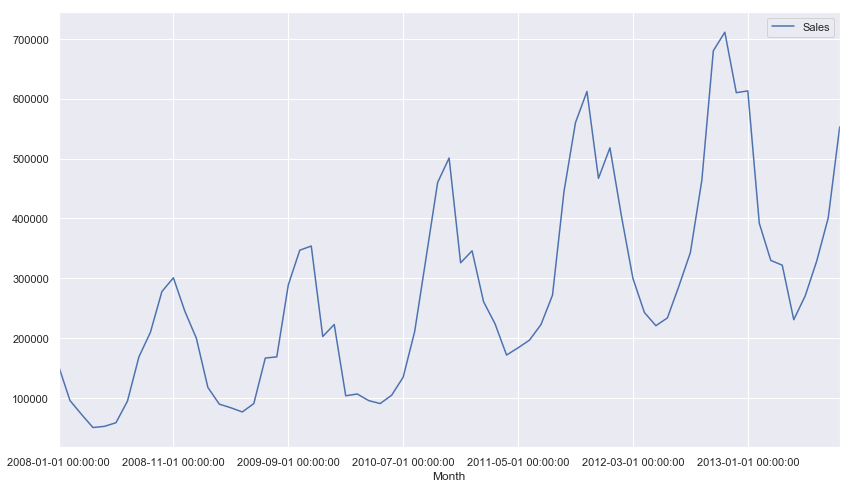

In [9]:
data.plot(kind='line')
plt.show()

It is clearly evident that there is an **overall increasing trend** in the data along with some seasonal variations.

We can check stationarity more formally using the **Dickey-Fuller Test**.

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

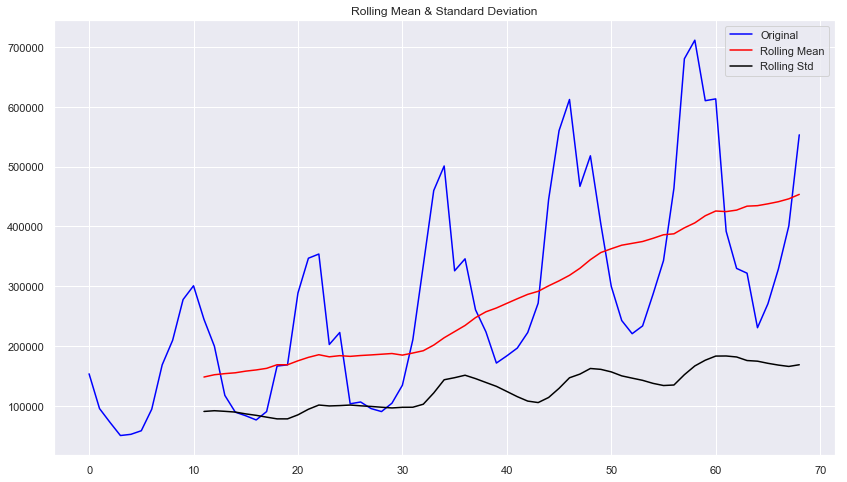

Results of Dickey-Fuller Test:
Test Statistic                 1.696
p-value                        0.998
#Lags Used                    11.000
Number of Observations Used   57.000
Critical Value (10%)          -2.595
Critical Value (1%)           -3.551
Critical Value (5%)           -2.914
dtype: float64


In [11]:
test_stationarity(data.iloc[:,0].values)

The mean is clearly increasing with time and this is not a stationary series. Note that the **signed values should be compared** and not the absolute ones.

* The test statistic is more than the 5% critical values
* the p-value is larger than 0.05

Thus, the moving average is not constant over time, and the null hypothesis of the Deckey-Fuller test cannot be rejected. This shows, that our time series is not stationary.

## Which records should be used as the holdout sample?

We need to predict the sales for the next 4 months, so we will use a holdout sample from the last four given months, i.e. June 2013 until Sep 2013.

In [12]:
data.tail(4)

,Sales
Month,
2013-06-01 00:00:00,271000
2013-07-01 00:00:00,329000
2013-08-01 00:00:00,401000
2013-09-01 00:00:00,553000


In [13]:
train = data.loc[:'2013-05-01']
train.index = pd.to_datetime(train.index)
test = data.loc['2013-06-01':]
test.index = pd.to_datetime(test.index)
test.shape

(4, 1)

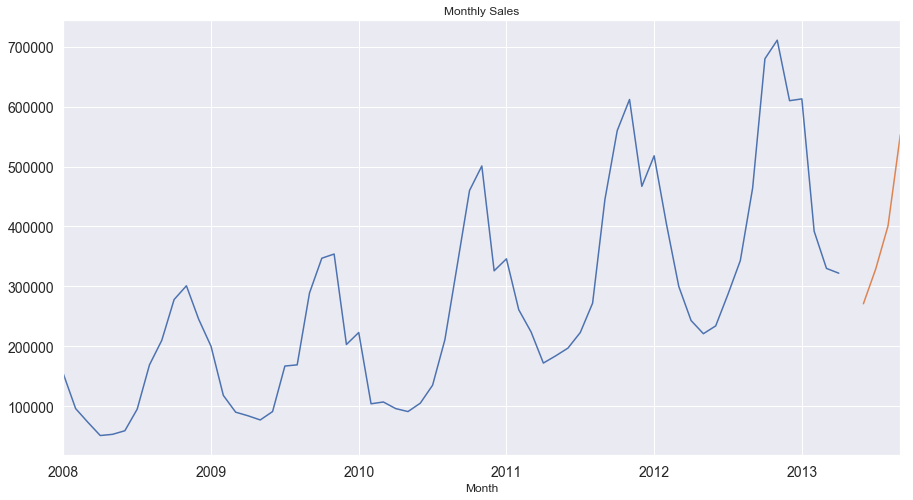

In [14]:
train.Sales.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.Sales.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
plt.show()

---

# **Step 2: Determine Trend, Seasonal and Error components**

Graph the data set and decompose the time series into its three main components: trend, seasonality, and error.

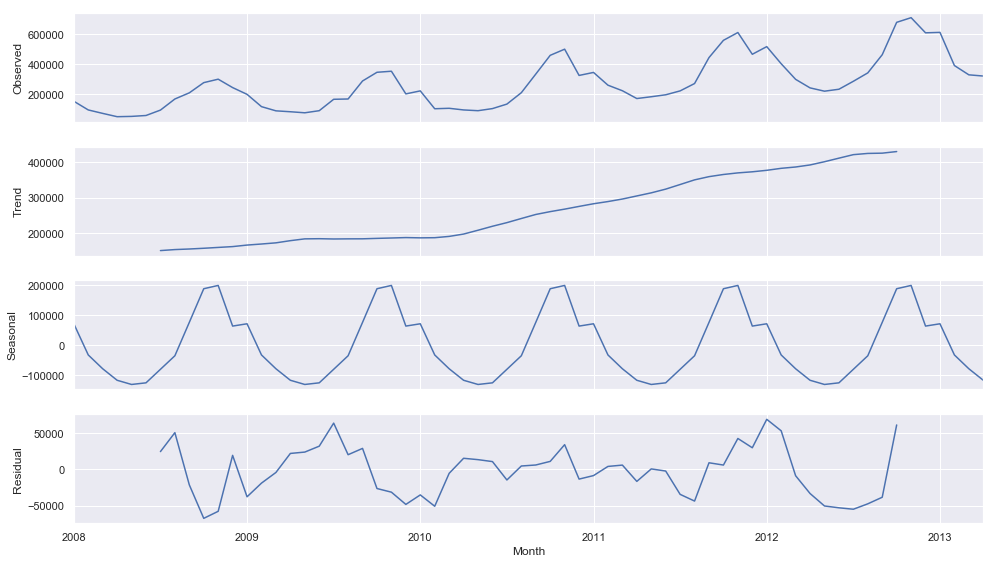

In [15]:
decomposition = seasonal_decompose(train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
plt.show()

In [16]:
seasonal.loc[seasonal.index.month==11]

,Sales
Month,
2008-11-01,199068.750
2009-11-01,199068.750
2010-11-01,199068.750
2011-11-01,199068.750
2012-11-01,199068.750


We have the scenario: Trend-Linear (see decomposition graph), Seasonal-Constant (sales amount doesn't change, constant every November).

* Error has no trend but has fluctuations, i.e. Multiplicative
* Trend goes up linear, i.e. Additive
* Seasonality remains constant, i.e. Additive

**Our Model: ETS(M,A,A).**

---

# **Step 3: Build your models - Forecasting a time series**

Determine the appropriate measurements to apply to your ARIMA and ETS models and describe the errors for both models.

## ETS Model

### Triple exponential smoothing a.k.a. Holt-Winters

Holt-Winters has an **advantage of not requiring data to be stationary** :)

In [17]:
model_hwes_nd = ExponentialSmoothing(train.Sales,
                             damped=False,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12).fit()
pred_hwes_nd = model_hwes_nd.predict(start=test.index[0], end=test.index[-1])
fitted_hwes_nd = model_hwes_nd.fittedvalues

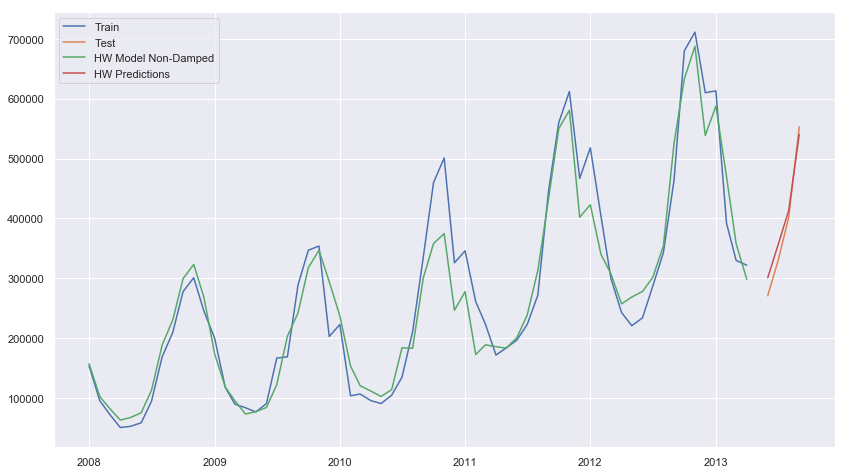

In [18]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(fitted_hwes_nd.index, fitted_hwes_nd, label='HW Model Non-Damped')
plt.plot(pred_hwes_nd.index, pred_hwes_nd, label='HW Predictions')
plt.legend(loc='best')
plt.show()

In [19]:
model_hwes_d = ExponentialSmoothing(train.Sales,
                             damped=True,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12).fit()
pred_hwes_d = model_hwes_d.predict(start=test.index[0], end=test.index[-1])
fitted_hwes_d = model_hwes_d.fittedvalues

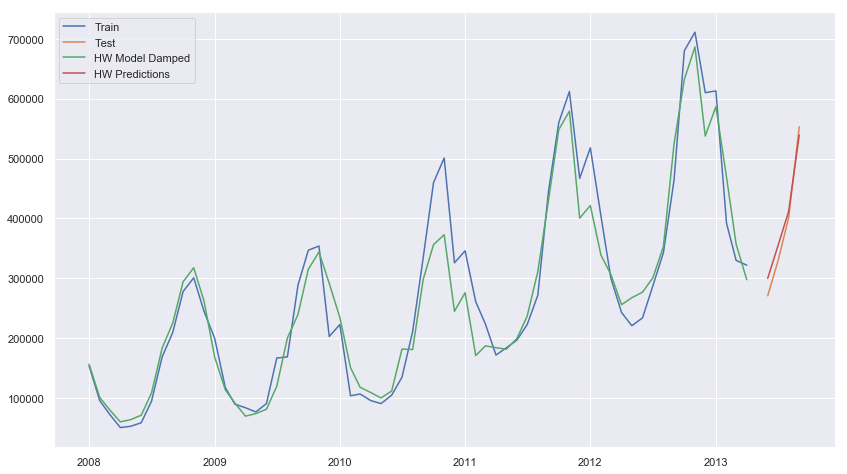

In [20]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(fitted_hwes_d.index, fitted_hwes_d, label='HW Model Damped')
plt.plot(pred_hwes_d.index, pred_hwes_d, label='HW Predictions')
plt.legend(loc='best')
plt.show()

In [21]:
print('Holt-Winters Non-Damped')
get_error(test.Sales, pred_hwes_nd)

Holt-Winters Non-Damped


,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,474691762.828,21787.422,19580.530,20219.567,0.005,6.083,0.957


In [22]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_nd)

0.3387852991357443

In [23]:
print('Holt-Winters Damped')
get_error(test.Sales, pred_hwes_d)

Holt-Winters Damped


,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,451190217.594,21241.239,19652.580,19787.888,0.004,5.918,0.960


In [24]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_d)

0.3315523726859261

We can substract the two DFs to compare the metrics better:

In [25]:
pd.DataFrame(get_error(test.Sales, pred_hwes_nd).iloc[1,:].sub(get_error(test.Sales, pred_hwes_d).iloc[1,:])).T

,0,1,2,3,4,5,6
Value,23501545.234,546.184,-72.050,431.679,0.000,0.165,-0.002


In [26]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_nd) - mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_d)

0.007232926449818211

We can see that MSE, RMSE, MAE and MAPE are smaller for damped HWSE model than non-damped, but the MDAE is bigger for damped HWSE model than non-damped. MSLE and R2 are about the same for both models.

Regarding MASE, the non-damped has a slight higher MASE (0.3389) compared to the damped version (0.3346).

**We would prefer the damped HWSE model for the higher accuracy.**

### Holt-Winters Exponential Smoothing Hyperparameter Optimization

Let's try to optimize the parameters instead with a grid search.

In [27]:
# grid search holt winter's exponential smoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array
 
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models
 
if __name__ == '__main__':
	# define dataset
	data = train.Sales.values
	print(data)
	# data split
	n_test = 4
	# model configs
	cfg_list = exp_smoothing_configs(seasonal=[12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	print('Top 3 found:')
	for cfg, error in scores[:3]:
		print(cfg, error)

[154000  96000  73000  51000  53000  59000  95000 169000 210000 278000
 301000 245000 200000 118000  90000  84000  77000  91000 167000 169000
 289000 347000 354000 203000 223000 104000 107000  96000  91000 105000
 135000 211000 335000 460000 501000 326000 346000 261000 224000 172000
 184000 197000 223000 272000 445000 560000 612000 467000 518000 404000
 300000 243000 221000 234000 287000 343000 464000 680000 711000 610000
 613000 392000 330000 322000]
 > Model[['add', True, 'add', 12, True, False]] 54712.921
 > Model[['add', True, 'add', 12, True, True]] 50659.663
 > Model[['add', True, 'add', 12, False, False]] 44897.627
 > Model[['add', True, 'add', 12, False, True]] 47280.864
 > Model[['add', True, 'mul', 12, True, False]] 55304.589
 > Model[['add', True, 'mul', 12, True, True]] 52820.191
 > Model[['add', True, 'mul', 12, False, True]] 50699.420
 > Model[['add', True, None, 12, True, True]] 106858.171
 > Model[['add', True, None, 12, True, False]] 107068.033
 > Model[['add', True, '

Running the optimization, we find, the best model with RSME of **41615.544** is:

* Trend: Additive
* Damped: False
* Seasonal: Additive
* Seasonal Periods: 12
* Box-Cox Transform: True
* Remove Bias: True

In [28]:
model_hwes_opt = ExponentialSmoothing(train.Sales,
                             damped=False,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12).fit(optimized=True, use_boxcox=True, remove_bias=False)
pred_hwes_opt = model_hwes_opt.predict(start=test.index[0], end=test.index[-1])
fitted_hwes_opt = model_hwes_opt.fittedvalues

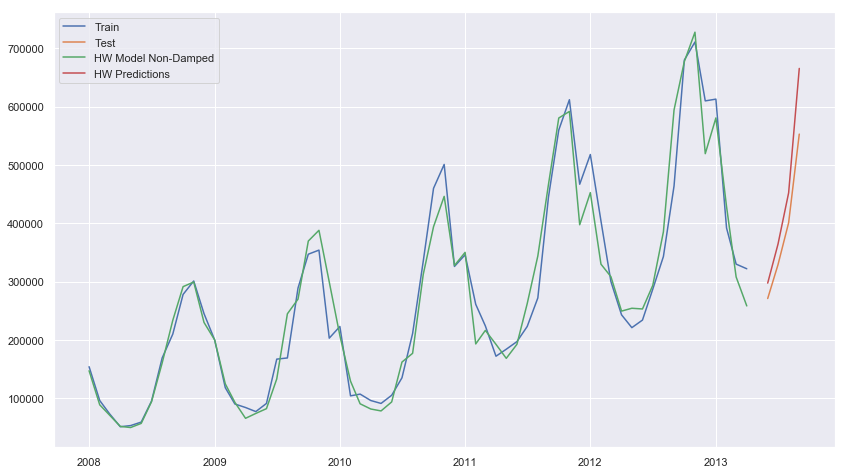

In [29]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(fitted_hwes_opt.index, fitted_hwes_opt, label='HW Model Non-Damped')
plt.plot(pred_hwes_opt.index, pred_hwes_opt, label='HW Predictions')
plt.legend(loc='best')
plt.show()

In [30]:
print('Holt-Winters Optimized')
get_error(test.Sales, pred_hwes_opt)

Holt-Winters Optimized


,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,4314468395.717,65684.613,43227.168,56391.021,0.017,13.403,0.613


In [31]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_opt)

0.9448495483638552

In [32]:
pd.DataFrame(get_error(test.Sales, pred_hwes_opt).iloc[1,:].sub(get_error(test.Sales, pred_hwes_d).iloc[1,:])).T

,0,1,2,3,4,5,6
Value,3863278178.124,44443.374,23574.588,36603.133,0.013,7.485,-0.347


In [33]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_opt) - mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_d)

0.6132971756779291

Wow, ok our damped model still performed better than our optimized model (especially the MASE bumped up to close to 1. It's still in the acceptable range under 1.0 but the difference is quite big. Either way, it's nice to see that our manual analysis is confirmed in almost the same parameters found in the optimization process!

## ARIMA Model

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        qq_ax = plt.subplot2grid(layout, (1, 0))
        pp_ax = plt.subplot2grid(layout, (1, 1))
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
        plt.show()
        
    lag_acf = acf(y, nlags=24)
    lag_pacf = pacf(y, nlags=24, method='ols')
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

    plt.show()

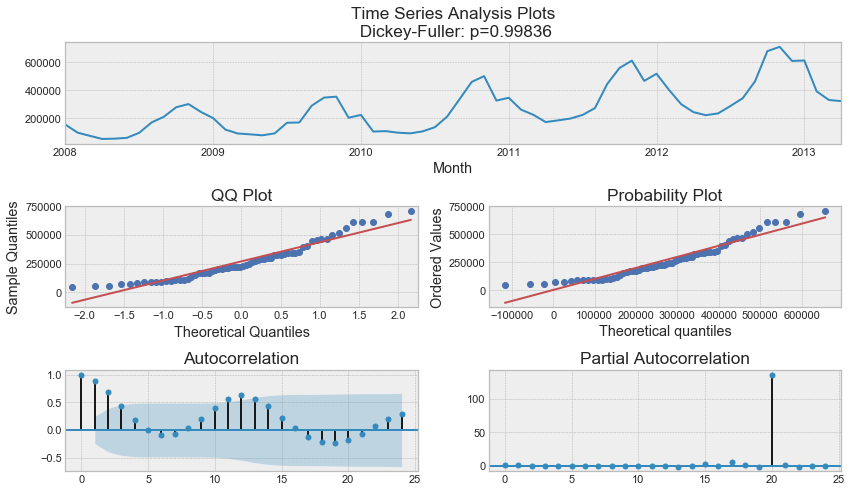

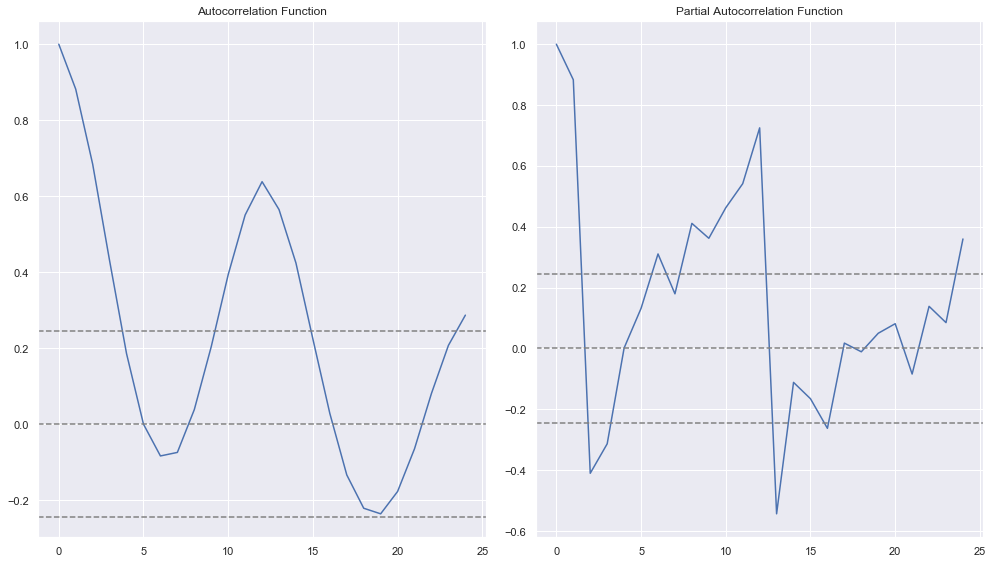

In [35]:
tsplot(train.Sales, lags=24)

## Estimating & eliminating trend

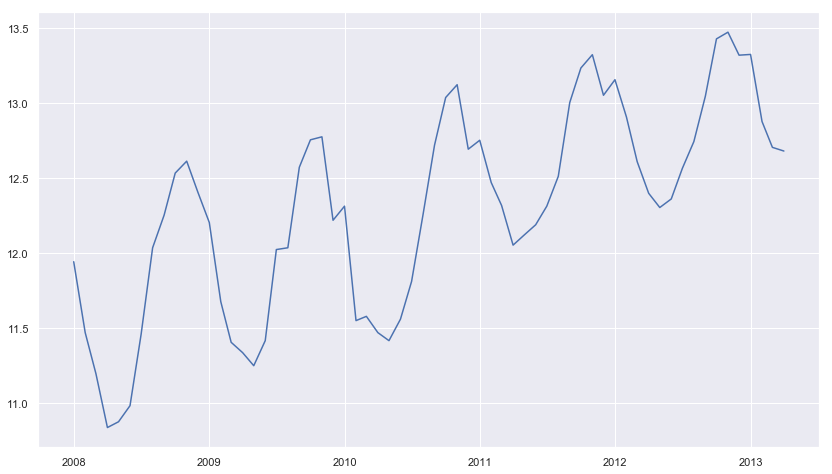

In [36]:
train_log = np.log(train)
plt.plot(train_log)
plt.show()

### Moving average

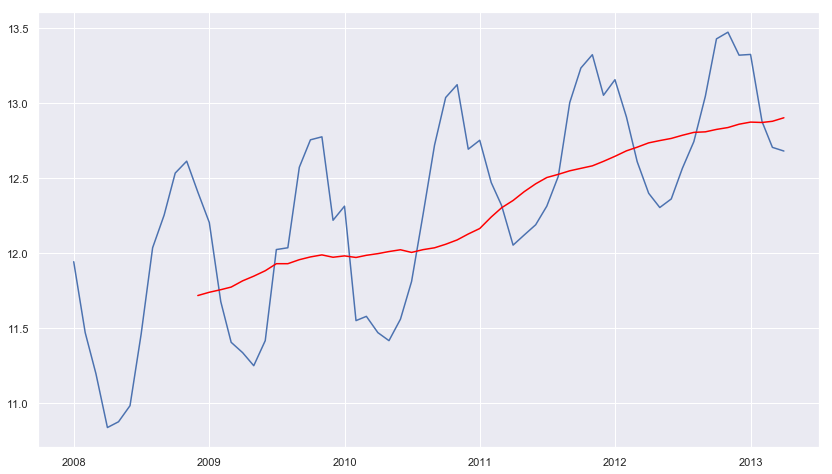

In [37]:
moving_avg = pd.rolling_mean(train_log,12)
plt.plot(train_log)
plt.plot(moving_avg, color='red')
plt.show()

In [38]:
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.head(12)

,Sales
Month,
2008-01-01,nan
2008-02-01,nan
2008-03-01,nan
2008-04-01,nan
2008-05-01,nan
2008-06-01,nan
2008-07-01,nan
2008-08-01,nan
2008-09-01,nan


Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.

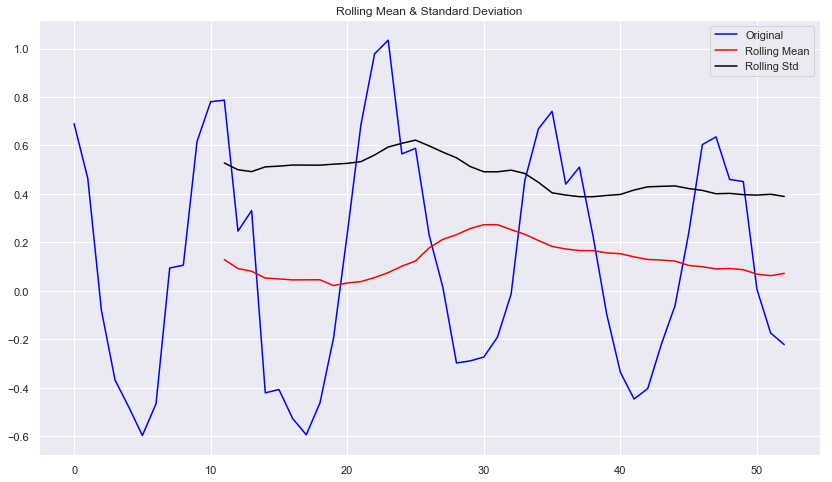

Results of Dickey-Fuller Test:
Test Statistic                -7.345
p-value                        0.000
#Lags Used                     4.000
Number of Observations Used   48.000
Critical Value (10%)          -2.600
Critical Value (1%)           -3.575
Critical Value (5%)           -2.924
dtype: float64


In [39]:
train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff.iloc[:,0].values)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. 

* the test statistic is **smaller than the 1% critical values** so we can say with 99% confidence that this is a stationary series
* The p-value is smaller than 0.05

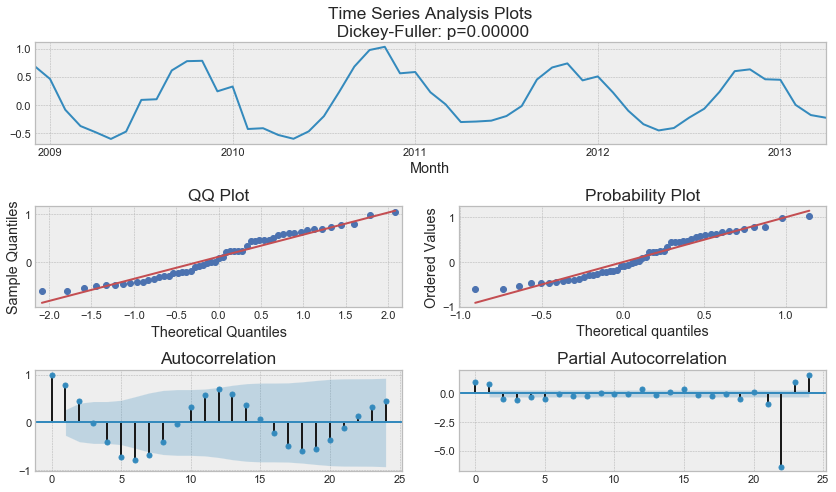

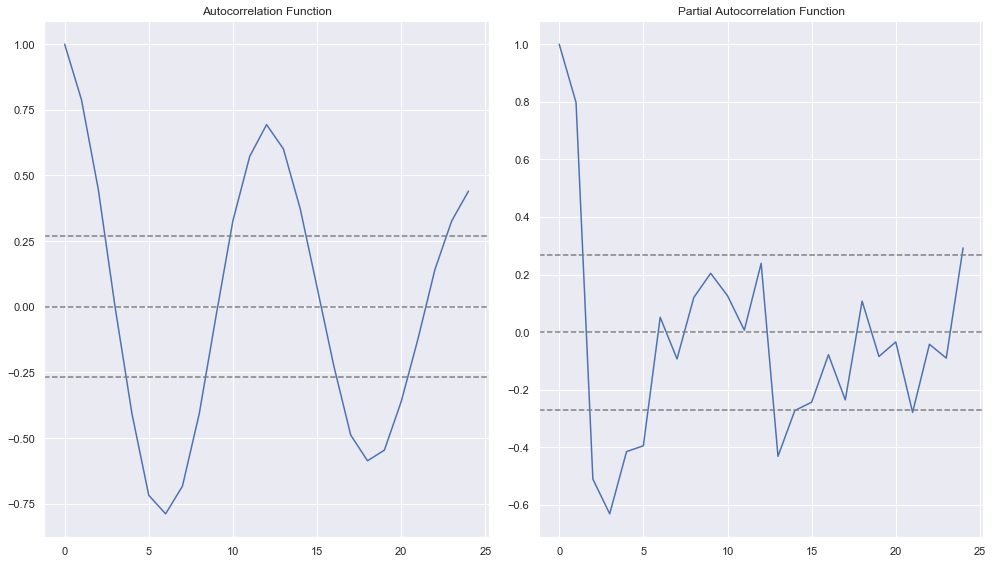

In [40]:
tsplot(train_log_moving_avg_diff.Sales, lags=24)

### Exponentially weighted moving average

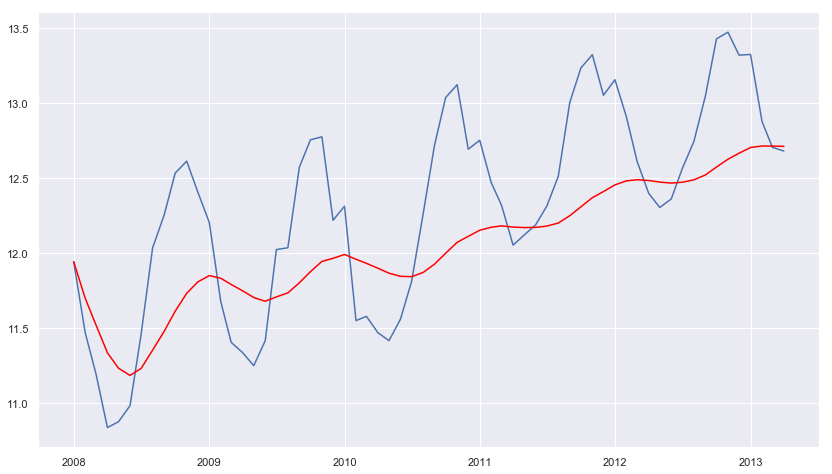

In [41]:
expwighted_avg = pd.ewma(train_log, halflife=12)
plt.plot(train_log)
plt.plot(expwighted_avg, color='red')
plt.show()

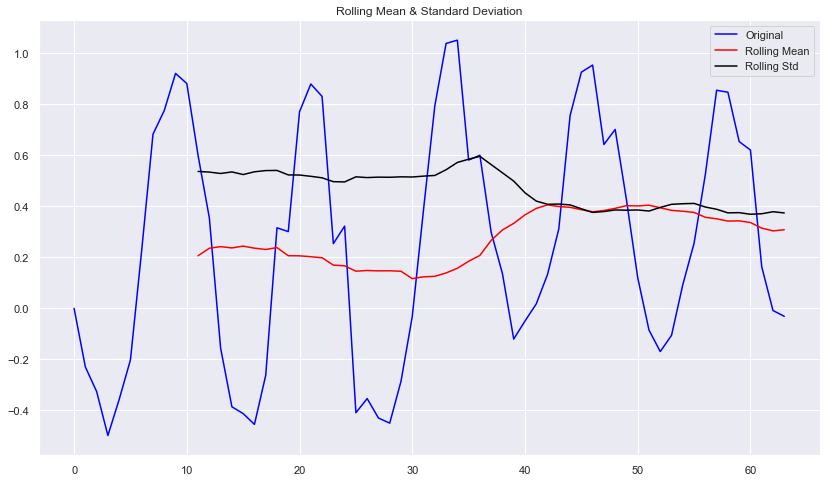

Results of Dickey-Fuller Test:
Test Statistic                -1.631
p-value                        0.467
#Lags Used                     8.000
Number of Observations Used   55.000
Critical Value (10%)          -2.596
Critical Value (1%)           -3.555
Critical Value (5%)           -2.916
dtype: float64


In [42]:
train_log_ewma_diff = train_log - expwighted_avg
test_stationarity(train_log_ewma_diff.iloc[:,0].values)

This TS does not notably have less variations in mean and SD in magnitude. The test statistic is not smaller than any critical value...

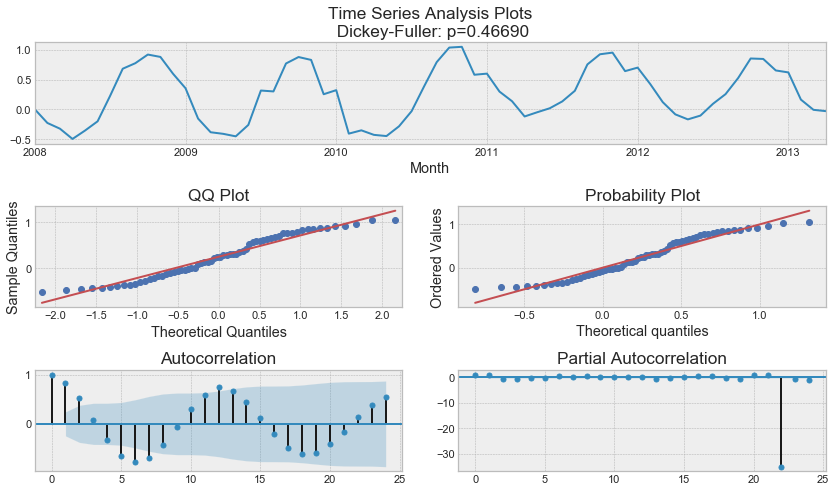

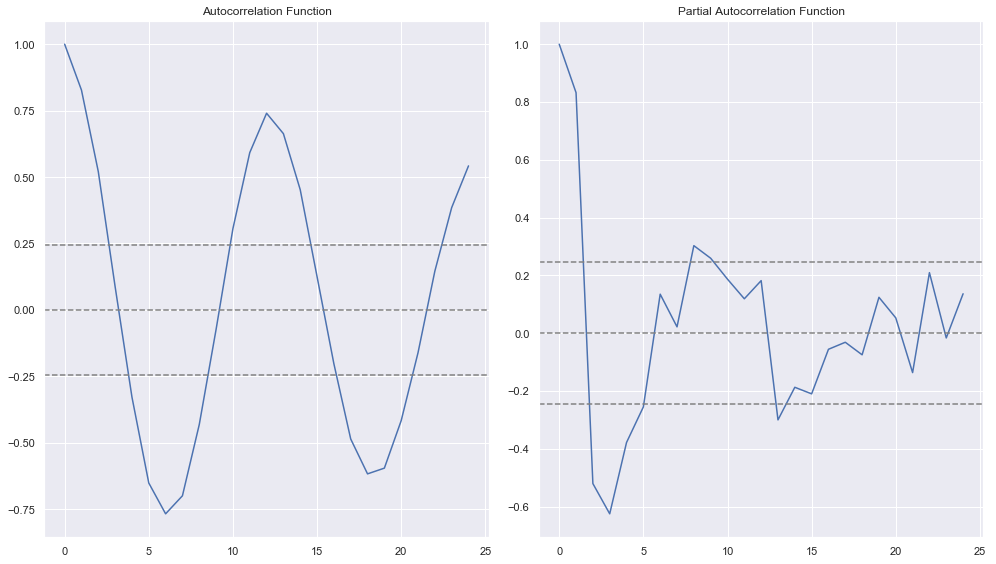

In [43]:
tsplot(train_log_ewma_diff.Sales, lags=24)

### Rolling average, remove trend

Summary: linear regression and rolling average can be used to remove the trend, here we can see a positive upwards trend. Removing the trend should help up

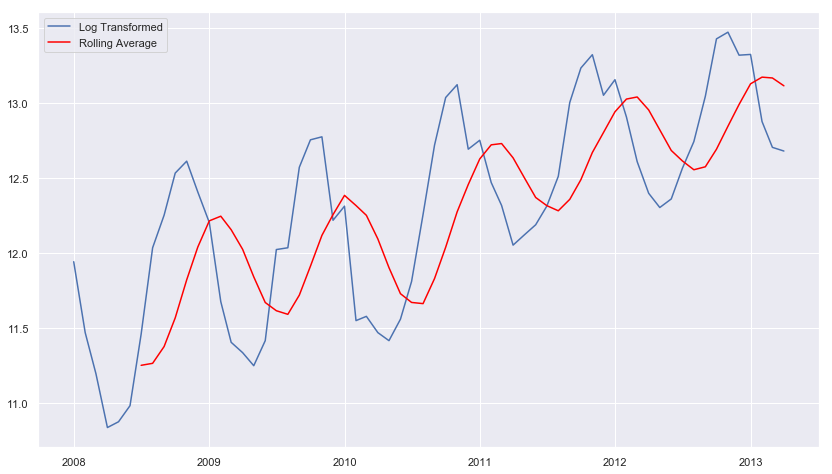

In [44]:
window = 7
rolling_average = train_log.rolling(window = window, center= False).mean()
train_log_rolling = rolling_average.dropna()
plt.plot(train_log, label = 'Log Transformed')
plt.plot(train_log_rolling, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

Notice that the RA is off, lets fix that to improve our representation of the data.

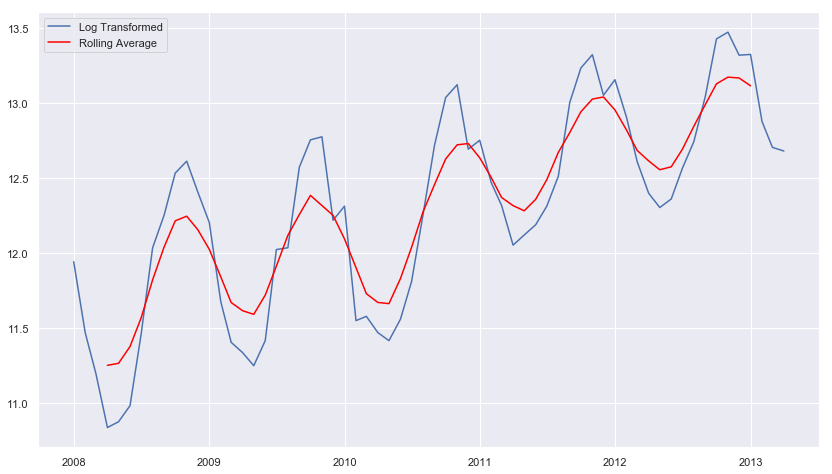

In [45]:
window = 7
shift_by_months = -3
rolling_average = train_log.rolling(window = window, center= False).mean()
train_log_rolling_temp = rolling_average.shift(shift_by_months).dropna()
plt.plot(train_log, label = 'Log Transformed')
plt.plot(train_log_rolling_temp, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')
plt.show()

Let's do a diff and figure out our new p-value.

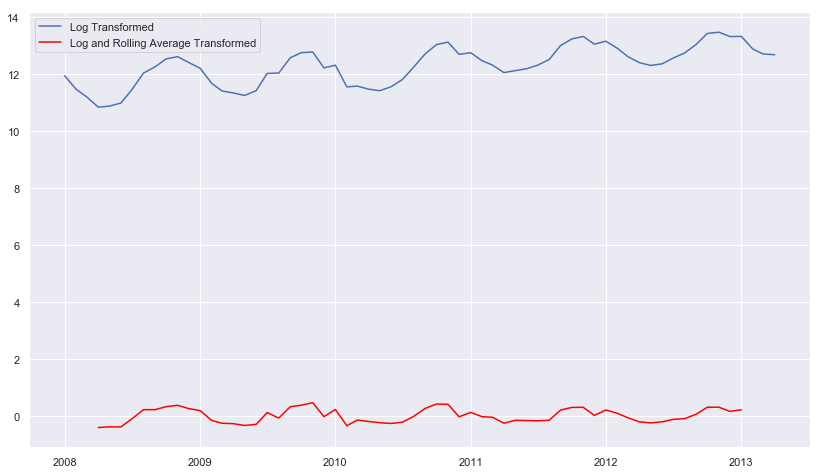

In [46]:
train_log_rolling = (train_log - train_log_rolling_temp).dropna()
plt.plot(train_log, label = 'Log Transformed')
plt.plot(train_log_rolling, color = 'red', label = 'Log and Rolling Average Transformed')
plt.legend(loc = 'best')
plt.show()

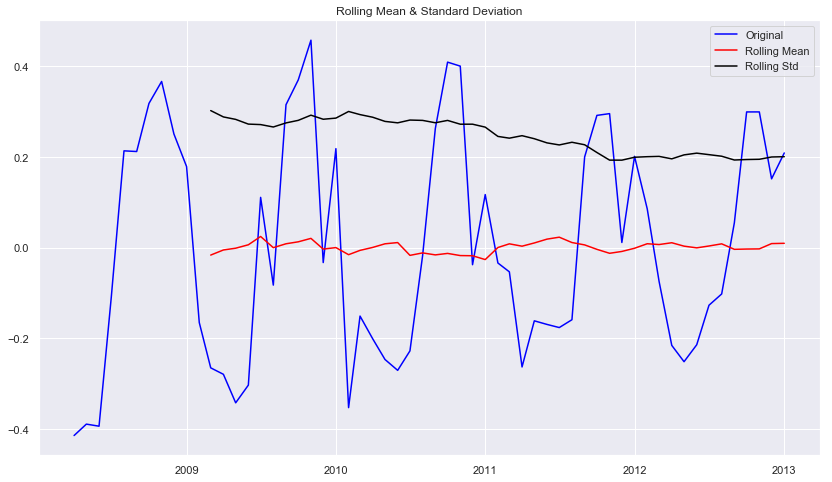

Results of Dickey-Fuller Test:
Test Statistic                -3.178
p-value                        0.021
#Lags Used                    11.000
Number of Observations Used   46.000
Critical Value (10%)          -2.602
Critical Value (1%)           -3.581
Critical Value (5%)           -2.927
dtype: float64


In [47]:
test_stationarity(train_log_rolling.Sales)

p-value 0.02 is less than our alpha of 0.05 - per this test it is stationary! 'Test Statistic' is significantly below the 'Critical Value (5%)', but not %1. The line itself looks stationary.

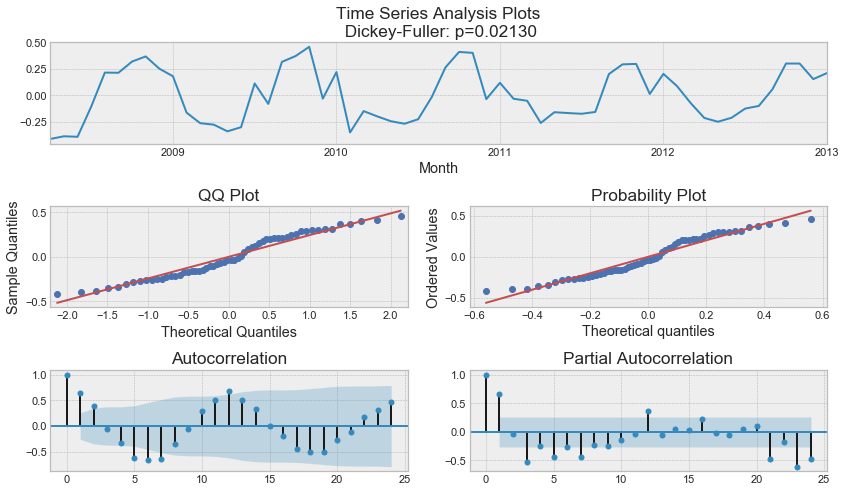

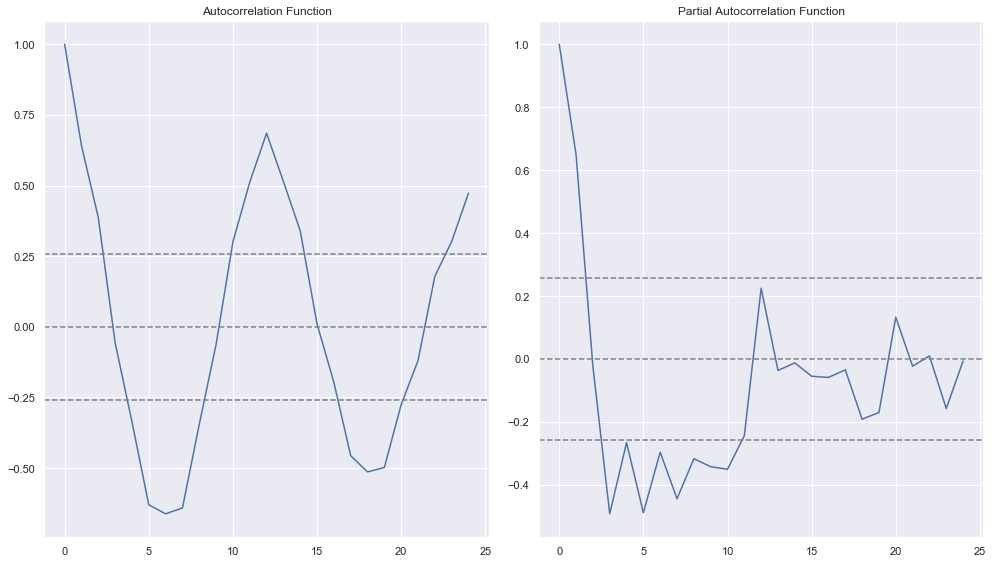

In [48]:
tsplot(train_log_rolling.Sales, lags=24)

## Decomposition

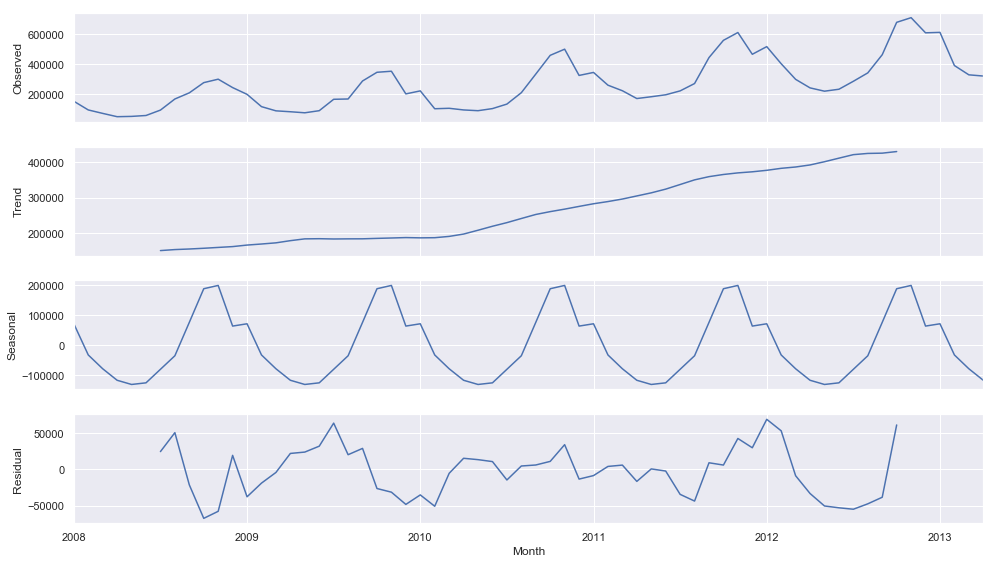

In [49]:
decomposition = seasonal_decompose(train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
plt.show()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

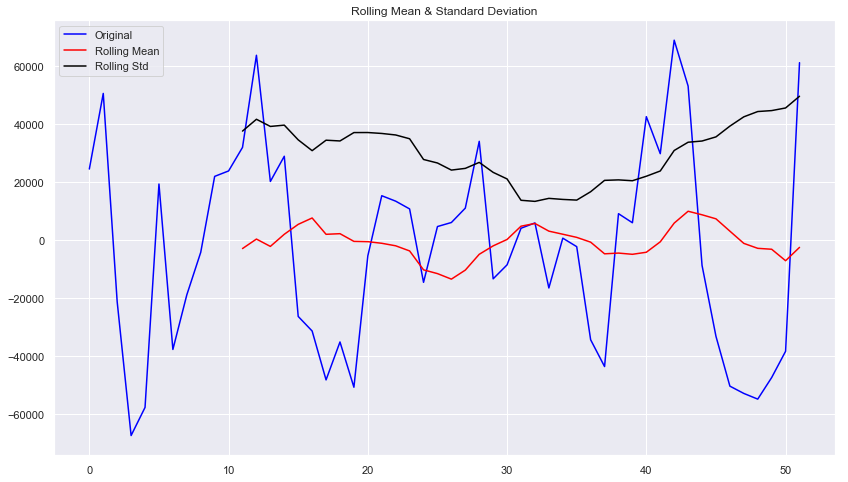

Results of Dickey-Fuller Test:
Test Statistic                -5.647
p-value                        0.000
#Lags Used                     5.000
Number of Observations Used   46.000
Critical Value (10%)          -2.602
Critical Value (1%)           -3.581
Critical Value (5%)           -2.927
dtype: float64


In [50]:
train_decompose = residual
train_decompose.dropna(inplace=True)
test_stationarity(train_decompose.iloc[:,0].values)

The Dickey-Fuller test statistic is significantly **lower than the 1% critical value**. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

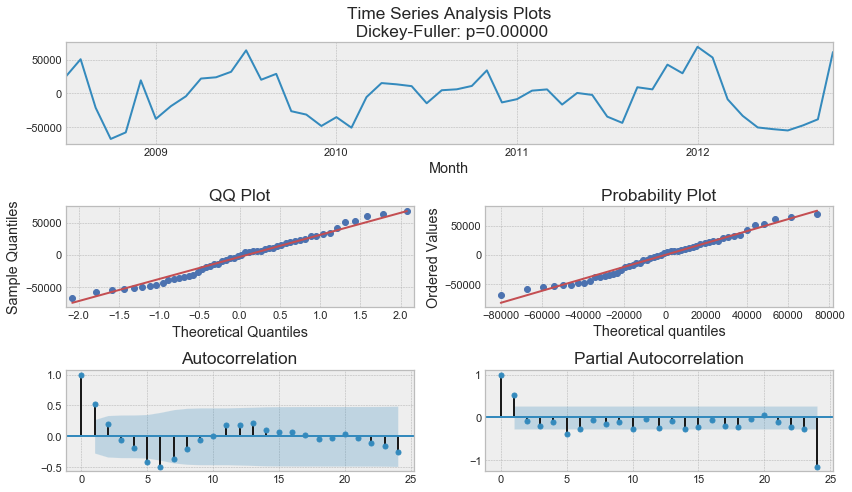

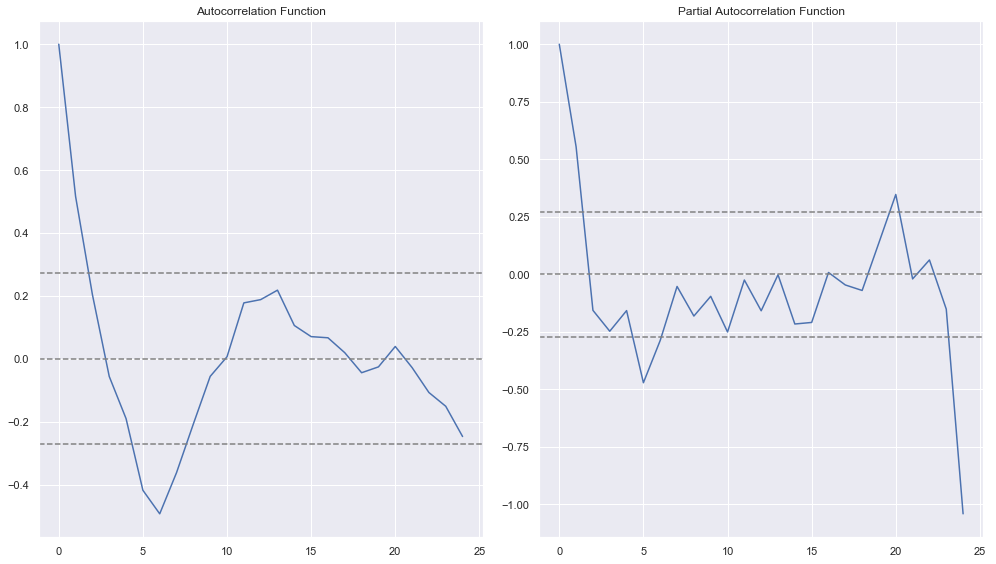

In [51]:
tsplot(train_decompose.Sales, lags=24)

This doesn't look too shabby! The ACF plot doesn't show as strong correlations anymore as opposed to previous methods.

**Overview of our prepared data:**

* `train` - original training data
* `train_log_rolling` - training data made stationary using differencing
* `train_decompose` - training data made stationary using decomposition

Let's use our stationary TS from the decomposition, since it showed the least autocorrelation.

In [52]:
ts = train_decompose

Analysis results: 
* `p` is most probably 5 since it is the last significant lag on the PACF, after which, most others are not significant.
* `d` equals 1 because we had first differences? or 0 because decomposition did not had any differencing?
* `q` should be somewhere around 6 as well as seen on the ACF
* `P` none of the seasonal lags in PACF seem to be significant, hence 0, but maybe it could be 2...
* `D` again equals 1 because we performed seasonal differentiation? or 0 because we didn't?
* `Q` none of the seasonal lags in ACF seem to be significant, hence 0.

In [53]:
# setting initial values and some bounds for them
ps = range(0, 7)
ds = [1]
qs = range(0, 7)
Ps = range(0, 2)
Ds = [1]
Qs = range(0, 2)
s = 12 # season length is still 12

# creating list with all the possible combinations of parameters
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

196

In [54]:
def optimizeSARIMA(parameters_list, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train.Sales, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [55]:
%%time
result_table = optimizeSARIMA(parameters_list, s)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/Claudi/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Claudi/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Claudi/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Claudi/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re


CPU times: user 39.1 s, sys: 4.06 s, total: 43.2 s
Wall time: 43.7 s


In [56]:
result_table.head()

,parameters,aic
0,"(1, 1, 1, 0, 1, 0)",1232.027
1,"(1, 1, 1, 1, 1, 0)",1232.890
2,"(1, 1, 2, 0, 1, 0)",1233.739
3,"(1, 1, 2, 1, 1, 0)",1234.605
4,"(1, 1, 3, 0, 1, 0)",1234.662


In [57]:
# set the parameters that give the lowest AIC
p, d, q, P, D, Q = result_table.parameters[0]

best_mod=sm.tsa.statespace.SARIMAX(train.Sales, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s))

best_res = best_mod.fit(disp=-1)
best_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   64
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood                -613.014
Date:                            Mon, 18 Feb 2019   AIC                           1232.027
Time:                                    19:34:58   BIC                           1237.823
Sample:                                01-01-2008   HQIC                          1234.242
                                     - 04-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7140      0.126      5.647      0.000       0.466       0.962
ma.L1         -0.9939      0.224     -4.432      0.000      -1.433      -0.554
sigma2      1.801e+09   1.25e-10   1.44e+19      0.000     1.8e+09     1.8e+09
===================================================================================
Ljung-Box (Q):                       34.69   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.71   Prob(JB):                         0.66
Heteroskedasticity (H):               1.22   Skew:                            -0.31
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.54e+34. Standard errors may be unstable.
"""

Let's inspect the residuals of the model.

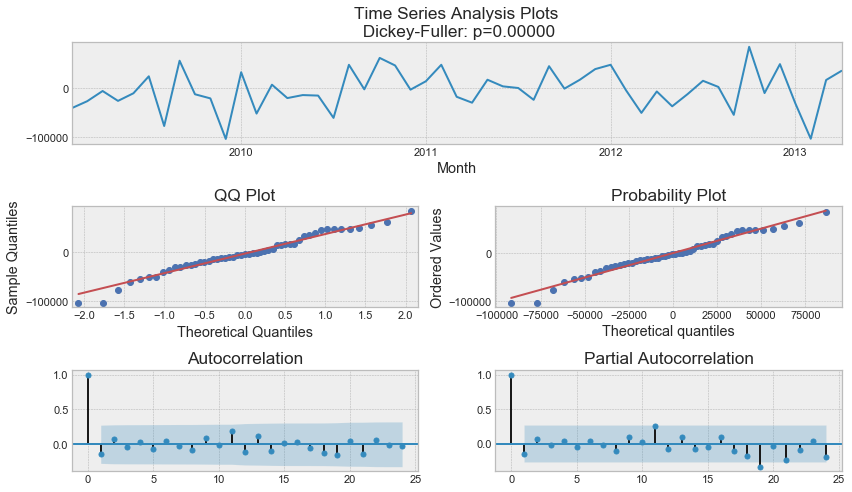

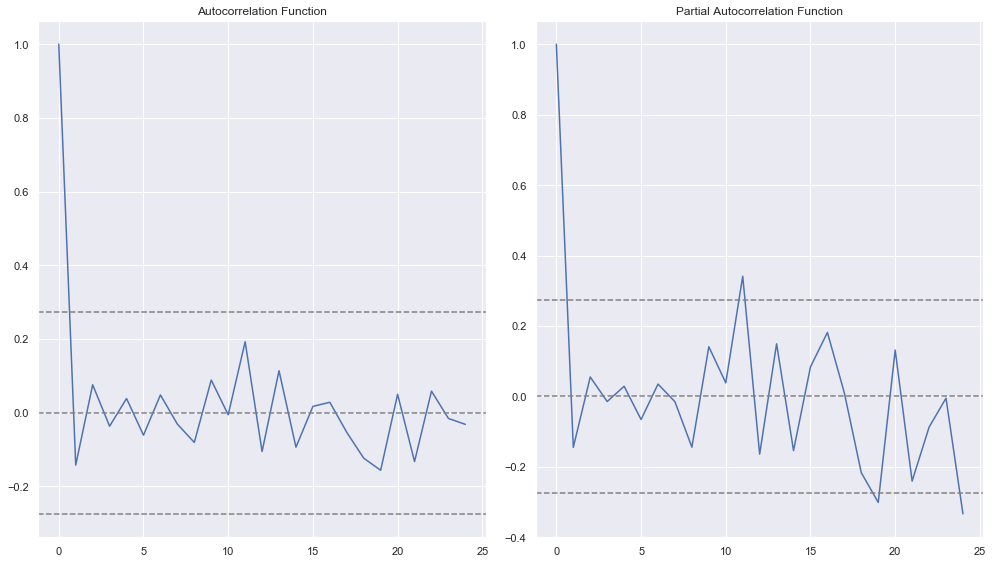

In [58]:
tsplot(best_res.resid[12+1:], lags=24)

It seems like the residuals are stationary, and there are no apparent autocorrelations at first, though the PACF does start to jump around :(

In [59]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)
    plt.show()

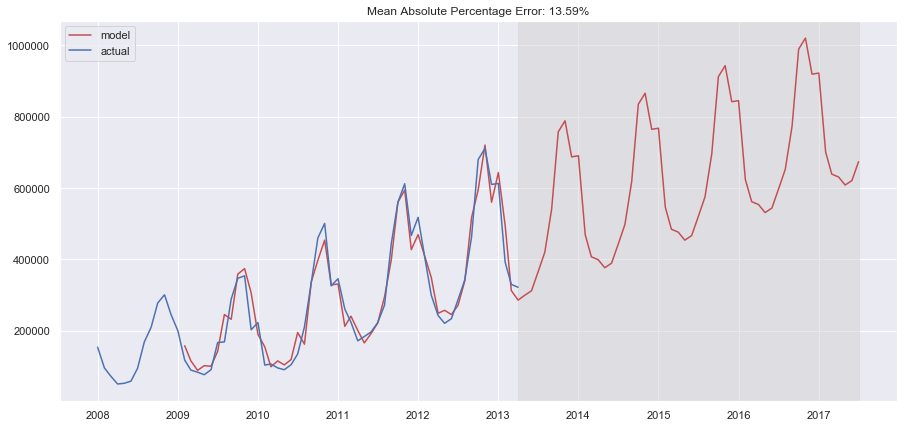

In [60]:
plotSARIMA(train, best_res, 50)

We have a MAPE of 13.59%! Not too bad.

In [61]:
pred_arima = best_res.predict(start=test.index[0], end=test.index[-1])

In [62]:
get_error(test.Sales, pred_arima)

,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,874444559.740,29571.009,27784.567,27035.469,0.008,8.266,0.922


In [63]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_arima)

0.4529879189721988

# Compare ETS and ARIMA

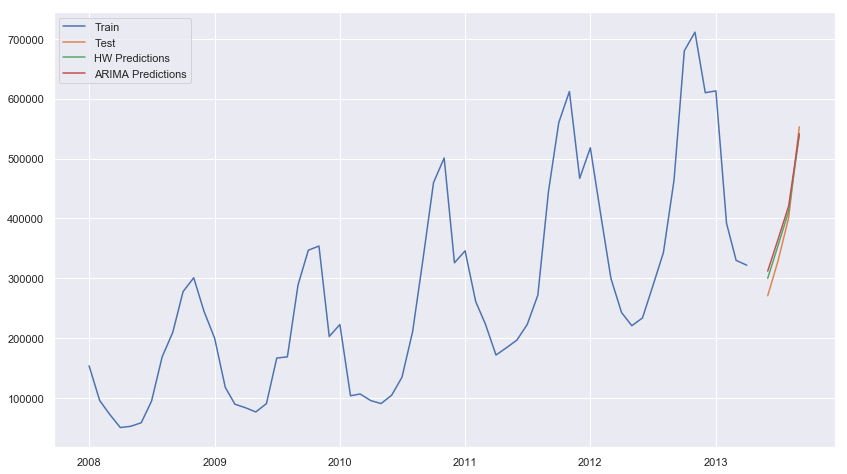

In [64]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred_hwes_d.index, pred_hwes_d, label='HW Predictions')
plt.plot(pred_arima.index, pred_arima, label='ARIMA Predictions')
plt.legend(loc='best')
plt.show()

In [65]:
get_error(test.Sales, pred_hwes_d)

,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,451190217.594,21241.239,19652.580,19787.888,0.004,5.918,0.960


In [66]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_hwes_d)

0.3315523726859261

In [67]:
get_error(test.Sales, pred_arima)

,0,1,2,3,4,5,6
Metric,MSE,RMSE,MDAE,MAE,MSLE,MAPE,R2
Value,874444559.740,29571.009,27784.567,27035.469,0.008,8.266,0.922


In [68]:
mean_absolute_scaled_error(train.Sales, test.Sales, pred_arima)

0.4529879189721988

In [69]:
pd.DataFrame(get_error(test.Sales, pred_arima).iloc[1,:].sub(get_error(test.Sales, pred_hwes_d).iloc[1,:])).T

,0,1,2,3,4,5,6
Value,423254342.147,8329.770,8131.987,7247.582,0.004,2.347,-0.038


The damped HW Exponential Smoothing model performed better than ARIMA – it has both a lower RMSE and MAPE.

---

# **Step 4: Forecast**

Compare the in-sample error measurements to both models and compare error measurements for the holdout sample in your forecast. Choose the best fitting model and forecast the next four periods.

**HINT:** When adding in the ACF and PACF plots, you should put in the original plots in your report and then after each term is added to the model include the resulting ACF and PACF plots. This helps us see the progression of why you are choosing the terms you are. Do not forget to include the plots after the final term that you determine is needed for the model as well. Be careful when plotting that you are selecting the new data you created after doing any differencing.

In [70]:
import calendar

In [71]:
def add_months(orig_date, n):
    # advance year and month by one month
    new_year = orig_date.year
    new_month = orig_date.month + n
    # note: in datetime.date, months go from 1 to 12
    if new_month > 12:
        new_year += 1
        new_month -= 12

    last_day_of_month = calendar.monthrange(new_year, new_month)[1]
    new_day = min(orig_date.day, last_day_of_month)

    return orig_date.replace(year=new_year, month=new_month, day=new_day)

In [72]:
forecast_beg = add_months(test.index[0], 4)
forecast_end = add_months(test.index[-1], 4)

In [74]:
fcast_arima = best_res.predict(start=train.index[0], end=forecast_end)
fcast_hwes_d = model_hwes_d.predict(start=train.index[0], end=forecast_end)

In [75]:
# confidence intervals
ci_arima_95 = best_res.get_forecast(9).conf_int(alpha=0.05).iloc[5:] # 95% CI
ci_arima_80 = best_res.get_forecast(9).conf_int(alpha=0.20).iloc[5:] # 80% CI

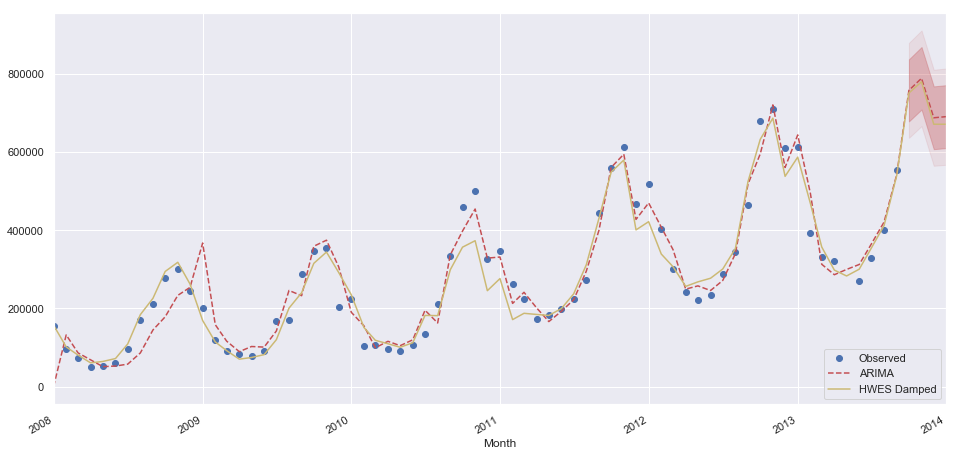

In [80]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))

# Plot data points
comb = train.append(test)
comb.Sales.plot(ax=ax, style='o', label='Observed')

# Plot predictions
fcast_arima.plot(ax=ax, style='r--', label='ARIMA')
ax.fill_between(ci_arima_95.index, ci_arima_95.iloc[:,0], ci_arima_95.iloc[:,1], color='r', alpha=0.1)
ax.fill_between(ci_arima_80.index, ci_arima_80.iloc[:,0], ci_arima_80.iloc[:,1], color='r', alpha=0.3)

fcast_hwes_d.plot(ax=ax, style='y', label='HWES Damped')

legend = ax.legend(loc='lower right')
plt.show()

The predictions are:

In [81]:
fcast_hwes_d.iloc[-4:]

2013-10-01   750740.217
2013-11-01   779390.732
2013-12-01   670872.884
2014-01-01   670807.384
Freq: MS, dtype: float64

In [82]:
fcast_arima.iloc[-4:]

2013-10-01   757467.575
2013-11-01   788400.640
2013-12-01   687352.848
2014-01-01   690318.725
Freq: MS, dtype: float64

# Code References

* https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
* https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/